**Midterm: Parks and Public Transit Access in LA County**

*Katrina Deloso & Ashley Yao*

Research Question: 

Identification of Data Sources:

In [1]:
# import libraries for: spatial data, plotting, network analysis, street network analysis, and basemaps

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import contextily as ctx

*Bus Data Exploration*

In [2]:
#import LA Bus Data
bus = gpd.read_file('data/LineServingStops1219.shp')

In [3]:
bus.head()

,STOPNUM,LINE,DIR_A2,STOPNAME,LAT,LONG,geometry
0,1,108,E,PARAMOUNT / SLAUSON,33.973248,-118.113113,POINT (-118.11311 33.97325)
1,1,265,S,PARAMOUNT / SLAUSON,33.973248,-118.113113,POINT (-118.11311 33.97325)
2,3,35,N,JEFFERSON / 10TH,34.025471,-118.328402,POINT (-118.32840 34.02547)
3,6,55,N,120TH \ AUGUSTUS F HAWKINS,33.924696,-118.242222,POINT (-118.24222 33.92470)
4,6,120,W,120TH \ AUGUSTUS F HAWKINS,33.924696,-118.242222,POINT (-118.24222 33.92470)


In [4]:
bus.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 19066 entries, 0 to 19065
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STOPNUM   19066 non-null  int64   
 1   LINE      19066 non-null  int64   
 2   DIR_A2    19066 non-null  object  
 3   STOPNAME  19066 non-null  object  
 4   LAT       19066 non-null  float64 
 5   LONG      19066 non-null  float64 
 6   geometry  19066 non-null  geometry
dtypes: float64(2), geometry(1), int64(2), object(2)
memory usage: 1.0+ MB


In [5]:
busTest = bus.loc[bus['LINE'] == 35]

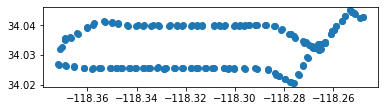

In [6]:
busTest.plot()

In [ ]:
#taking bus line coordinates and turning them into place values
place = (bus['LAT'],bus['LONG'])
type(place)

In [ ]:
# narrowing down for Elysian route Lines 2 and 4
busELY = bus.loc[bus['LINE']==4]
placeELY = (busELY['LAT'],busELY['LONG'])
busELY.head()

In [ ]:
# variables set
network_type = 'walk'
trip_times = [5,10,15]
meters_per_minute = 75

In [ ]:
#downloading street network
def isomap(gdf):
    G = ox.graph.graph_from_point(center_point,dist = 2000, dist_type='bbox',
                              network_type='walk', simplify=True, retain_all=False, 
                              truncate_by_edge=False, clean_periphery=True, custom_filter=None)

#project to web mercator
    G = ox.project_graph(G,to_crs='epsg:3857')

#convert nodes and edges to geodata frames
    gdf_nodes,gdf_edges = ox.graph_to_gdfs(G)
   
    # establishing centroid
    minx,miny,maxx,maxy = gdf_nodes.geometry.total_bounds
    centroid_x = (maxx-minx)/2 + minx
    centroid_y = (maxy-miny)/2 + miny
    
    # selecting closest node
    center_node = ox.get_nearest_node(G, 
                                  (centroid_y,centroid_x), 
                                  method = 'euclidean')
    
    # isochrone building
    gdf_edges['walk_time'] = gdf_edges['length']/meters_per_minute
    
    iso_colors = ox.plot.get_colors(n=len(trip_times),
                                   cmap = 'plasma',
                                   start = 0,
                                   return_hex = True)
    trip_times.sort(reverse = True)
    time_color = list(zip(trip_times,iso_colors))
    time_color
    gdf_nodes,gdf_edges = ox.graph_to_gdfs(G)
    
    # legend
    for time, color in list(time_color):
        subgraph = nx.ego_graph(G,center_node, radius = time, distance = 'time')
        for node in subgraph.nodes():
            gdf_nodes.loc[node,'time'] = str(time)+' mins'
            gdf_nodes.loc[node,'color'] = color
    gdf_nodes['color'].fillna('#cccccc', inplace = True)  
    isochrones = gdf_nodes.dissolve('time')
    isochrones = isochrones.convex_hull.reset_index()
    isochrones.columns = ['time', 'geometry']
    
    
    fig, ax = plt.subplots(figsize=(10,10))
    
    gdf_edges.plot(ax=ax, linewidth = 0.75, alpha = 0.2, edgecolor = 'gainsboro', zorder = 10)
    gdf_nodes.loc[[center_node]].plot(ax=ax, color = 'g', zorder = 30)
    
    
    # add isochrones
    isochrones.plot(alpha = 0.4, ax = ax, column = 'time', cmap = 'viridis', legend = True, zorder = 20)
    ax. axis('off')
    ax.set_title('Walksheds from LA Metro Bus Stop' + row['STOPNAME'])
    
    # basemap
    ctx.add_basemap(ax,source = ctx.providers.CartoDB.Positron)
        
            

In [ ]:
for index, row in busELY.iterrows():
    center_point = row[4],row[5]
    isomap(busELY)